In [1]:
import os
import pandas as pd
from Bio import SeqIO
# import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.spatial
import random
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import Normalize
from matplotlib.patches import Patch


os.chdir('/Users/callamartyn/chou_lab/alongshan/paper_repo/')

In [186]:
rdrp_sum=pd.read_csv('./rdrp_sum.csv') # summary of all rdrp-containing cluster representative sequences
# sample_sum=pd.read_csv('./sample_sum.csv') # summary of samples
# cov_long=pd.read_csv('./contig_coverage.csv') # coverage table

In [3]:

virus=list(rdrp_sum[rdrp_sum.type=='virus'].contig_id) # list of contig ids corresponding to viral genomes
vlt=list(rdrp_sum[rdrp_sum.type=='vlt'].contig_id)# list of contig ids corresponding to vlt sequences
samples=cov_long[cov_long.sample_type=='exp'].sample_id.unique() # list of sample names


In [139]:
input_seq_iterator=SeqIO.parse('./all_contigs_prot.fasta', 'fasta')
seqs=[]
for r in input_seq_iterator:
    sub_id=re.sub('_[0-9]$', '',r.id)
    for s in virus:
        if sub_id == s:
            seqs.append(r)
SeqIO.write(seqs,'./virus_rep_proteins.fasta', 'fasta')

Preparing coverage data for heatmap visualization

In [79]:
#selecting only viral genomes and filtering for coverage to be 10X median control value
virus_lcov=cov_long[(cov_long.contig_id.isin(virus))&(cov_long.mass>10*cov_long.control_mass)&
                    (cov_long.mass>1e-5)&
                    (cov_long.sample_type=='exp')]
#adding virus name to view as rownames
# virus_lcov.insert(0, 'virus_name', virus_lcov.contig_id.map(dict(zip(rdrp_sum.contig_id, rdrp_sum.virus_name))))

#some samples will be missing from table if they had no reads aligning to any of the contigs
present=list(virus_lcov.sample_id.unique())
missing=[x for x in samples  if x not in present] #list of samples with no reads to any viral genome
d = dict.fromkeys(missing, 0) #dictionary of missing samples to 0 (for all contigs)

#pivot to wide form for heatmap
virus_wcov=virus_lcov.pivot(columns='sample_id',index='cluster_85',values='tpm').fillna(0) 
virus_wcov=virus_wcov.assign(**d) # adding back in missing samples with 0 value throughout


In [170]:
df=virus_wcov.append(vlt_wcov)
df[df>0]=1
vprev=pd.DataFrame(df.sum(axis=1), columns=['n_prev']).reset_index()
rdrp_sum.insert(5, 'n_prevalence',rdrp_sum.cluster_85.map(dict(zip(vprev.cluster_85, vprev.n_prev))))
rdrp_sum.to_csv('./rdrp_sum.csv', index=False)

In [189]:
df=rdrp_sum[rdrp_sum.type=='virus'][['virus_name', 'tree_family', 'n_prevalence', 'length', 'no_orfs', 'stitle', 'blast_pident']]
df.insert(2,'Prevalence', df.n_prevalence/100)
df.drop(columns='n_prevalence',inplace=True)
df
df=df.rename(columns={'virus_name': 'Virus Name', 'tree_family': 'Viral Family', 'length': 'Length', 
                   'no_orfs':'Number ORFs', 'stitle':'Blast Hit', 'blast_pident':'Blast % Identity'})
df.to_csv('./virus_summary_table.csv',index=False)

In [10]:
#repeating for vlt contigs
vlt_lcov=cov_long[(cov_long.contig_id.isin(vlt))&(cov_long.mass>10*cov_long.control_mass)&(cov_long.sample_type=='exp')]
present=list(vlt_lcov.sample_id.unique())
missing=[x for x in samples  if x not in present]
d = dict.fromkeys(missing, 0)
vlt_wcov=vlt_lcov.pivot(columns='sample_id',index='cluster_85',values='tpm').fillna(0)
vlt_wcov=vlt_wcov.assign(**d)


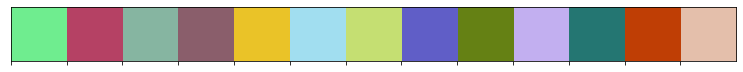

In [7]:
pal=["#6fed8f", "#b54164", "#86b5a1", "#8a5e6b","#eac328", "#a1def0", "#c5df72", "#605ec7", "#658114", 
      "#c2aff0", "#247672", "#bf3e05", "#e4bfab"]
sns.palplot(pal)

In [8]:
# setting parameters for heatmaps
cmap = sns.cm.mako_r
cmap.set_bad("white") 
sns.set(font_scale = 2)

#dictionaries mapping sampels to values (for adding row and column colors)
ls_dict=dict(zip(sample_sum.sample_id, sample_sum.life_stage))
family_dict=dict(zip(rdrp_sum['cluster_85'], rdrp_sum['tree_family']))
lib_dict=dict(zip(sample_sum.sample_id, sample_sum.nonhost_reads)) 

# colormap for libary size
cmap2 = sns.cm.flare 
libsizes=list(lib_dict.values())
# normalizing and setting max value to be 4 million reads, otherwise 12 million read library washes everything out
norm = Normalize(vmin=50000, vmax=4e6) 


#dictionaries mapping values to colors
random.seed(20)
r_lut=dict(zip(sorted(rdrp_sum['tree_family'].unique()), sns.color_palette(palette=pal)))
#! remember to add grey back here for na if 
c_lut={'male':'lightskyblue', 'female':'lightgreen', 'nymph':'khaki'}
c_lut2=dict(zip(libsizes, cmap2(norm(libsizes))))

<ipython-input-8-a7995884be7c>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("mako_r").copy()
  cmap.set_bad("white")


Virus Heatmap

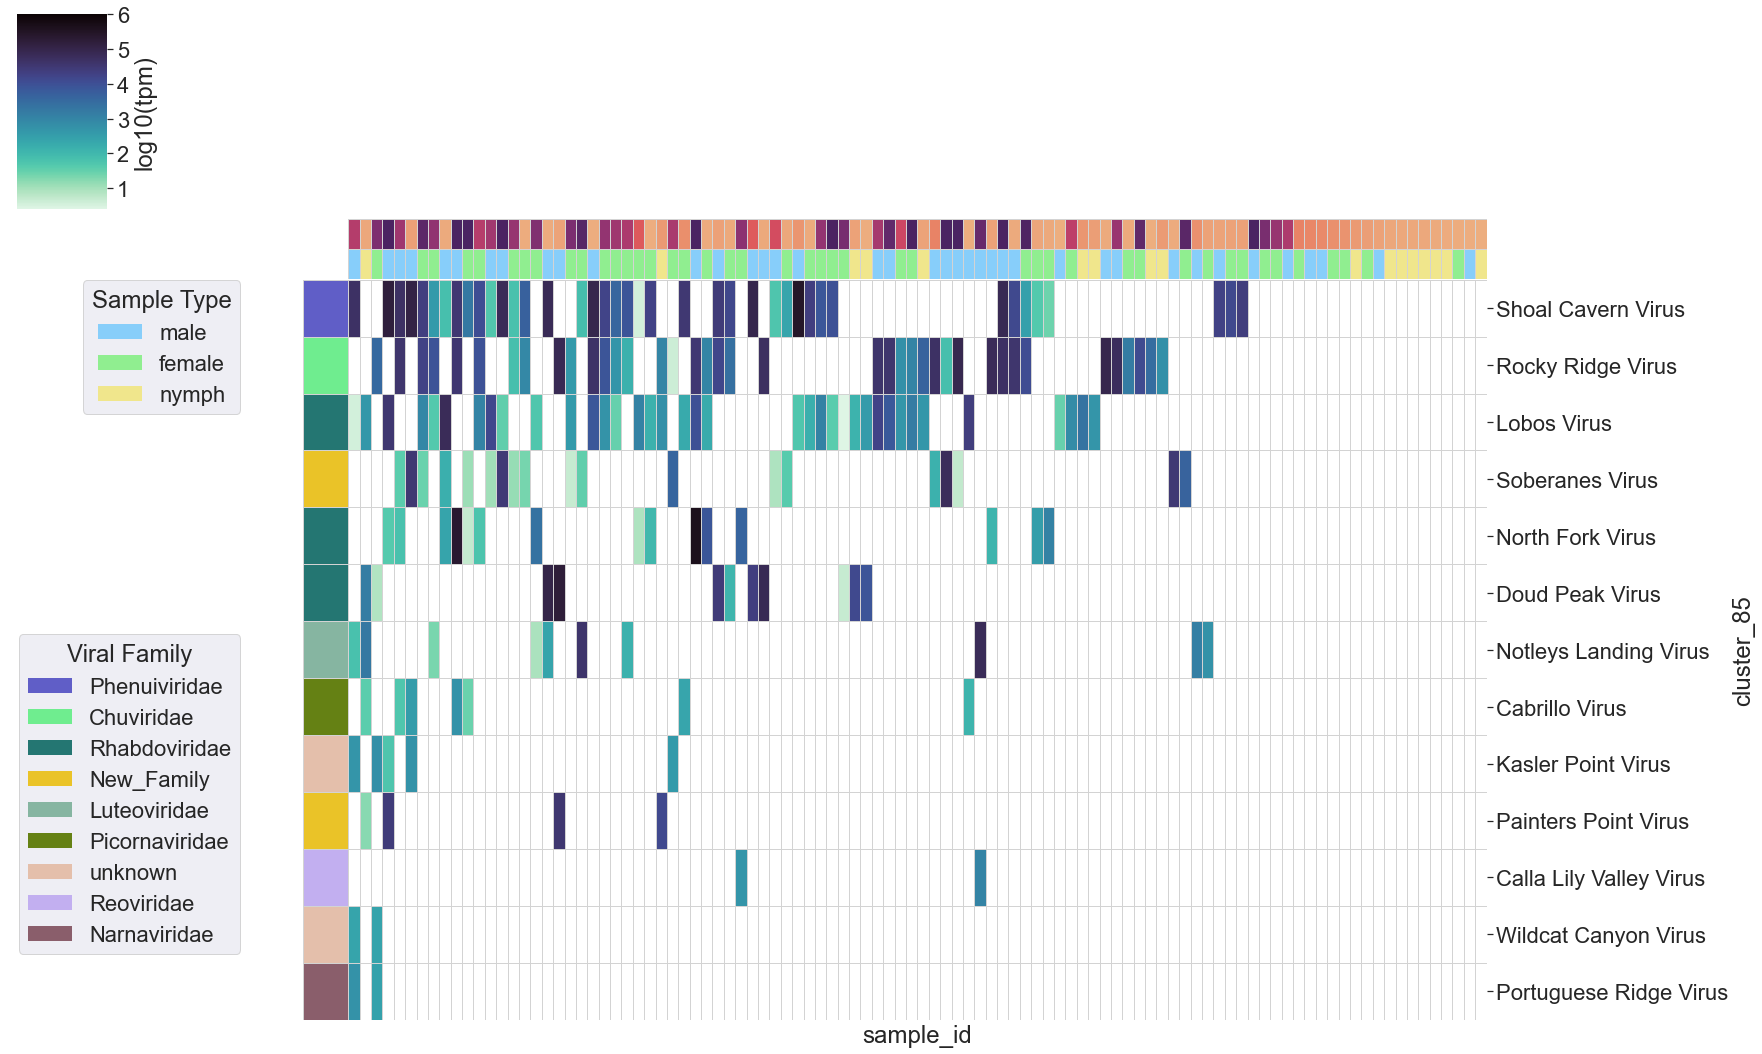

In [165]:
p=virus_wcov.copy() #creating prevalence dataframe to order rows and columns
p[p>0]=1
vprev=pd.DataFrame(p.sum(axis=1), columns=['n_prev']).reset_index() # prevalence of each virus
vprev['per_prev']=vprev.n_prev/virus_wcov.shape[1]
sprev=pd.DataFrame(p.sum(axis=0), columns=['n_prev']).reset_index() # number of viruses per sample

#reordering the rows and columns, first by prevalence, then by cluster (if prevalence is equal)
sc=AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='ward').fit_predict(p.transpose())
sprev['cluster']=sc
colorder=sprev.sort_values(by=['n_prev','cluster'],ascending=False).sample_id #sort first by number of virues, then by cluster

vc=AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward').fit_predict(p)
vprev['cluster']=vc
roworder=vprev.sort_values(by=['n_prev','cluster'],ascending=False).cluster_85 #sort first by prevalence, then by cluster

virus_wcov=virus_wcov.loc[roworder,colorder] #reordering dataframe

#setting row and column colors
random.seed(20)
row_colors = virus_wcov.index.map(family_dict).map(r_lut)
col_colors=virus_wcov.columns.map(ls_dict).map(c_lut)
col_colors2=virus_wcov.columns.map(lib_dict).map(c_lut2)
     
#log scaling, otherwise very high tpm values wash everything out
virus_log=virus_wcov.copy()
virus_log[virus_log==0]=.000001 # adding pseudocount to cells with 0 reads
virus_log=np.log10(virus_log)
virus_log[virus_log<=-6]=0 # setting pseudocount cells back to 0

#switching out cluster ids for virus names
virus_log=virus_log.set_index(virus_log.index.map(dict(zip(rdrp_sum.cluster_85, rdrp_sum.virus_name))))
#plotting
virus_clust=sns.clustermap(data = virus_log,cmap = cmap, vmax=6, mask=(virus_log==0), row_colors=[row_colors],
                           col_colors=[col_colors2, col_colors], yticklabels=1, xticklabels=False, col_cluster=False,
                           row_cluster=False, figsize=(25,15),linecolor='lightgrey', linewidth=.5,
                           cbar_kws={"ticks":[-1, 0,1,2,3,4,5,6], 'label': 'log10(tpm)'})


for label in virus_wcov.index.map(family_dict).unique():
    virus_clust.ax_row_dendrogram.bar(0, 0, color=r_lut[label], label=label, linewidth=0);
virus_clust.ax_row_dendrogram.legend(title='Viral Family', loc="lower right", bbox_to_anchor=(.15, .1), 
                                   bbox_transform=plt.gcf().transFigure)

for label in c_lut.keys():
    virus_clust.ax_col_dendrogram.bar(0, 0, color=c_lut[label], label=label, linewidth=0);
virus_clust.ax_col_dendrogram.legend(title='Sample Type', loc="lower right", bbox_to_anchor=(.15, .6), 
                                   bbox_transform=plt.gcf().transFigure)
# virus_clust.savefig('../out/plots/Virus/virus_clustmap.pdf')

In [168]:
vprev['virus_name']=vprev.cluster_85.map(dict(zip(rdrp_sum.cluster_85, rdrp_sum.virus_name)))
vprev

,cluster_85,n_prev,per_prev,cluster,virus_name
0,Cluster 4,40.0,0.40,7,Shoal Cavern Virus
1,Cluster 8,39.0,0.39,5,Rocky Ridge Virus
2,Cluster 10,37.0,0.37,4,Lobos Virus
3,Cluster 1,19.0,0.19,3,Soberanes Virus
4,Cluster 5,15.0,0.15,6,North Fork Virus
5,Cluster 6,11.0,0.11,2,Doud Peak Virus
6,Cluster 876,10.0,0.10,1,Notleys Landing Virus
7,Cluster 16,7.0,0.07,0,Cabrillo Virus
8,Cluster 517,5.0,0.05,0,Kasler Point Virus
9,Cluster 13,4.0,0.04,0,Painters Point Virus


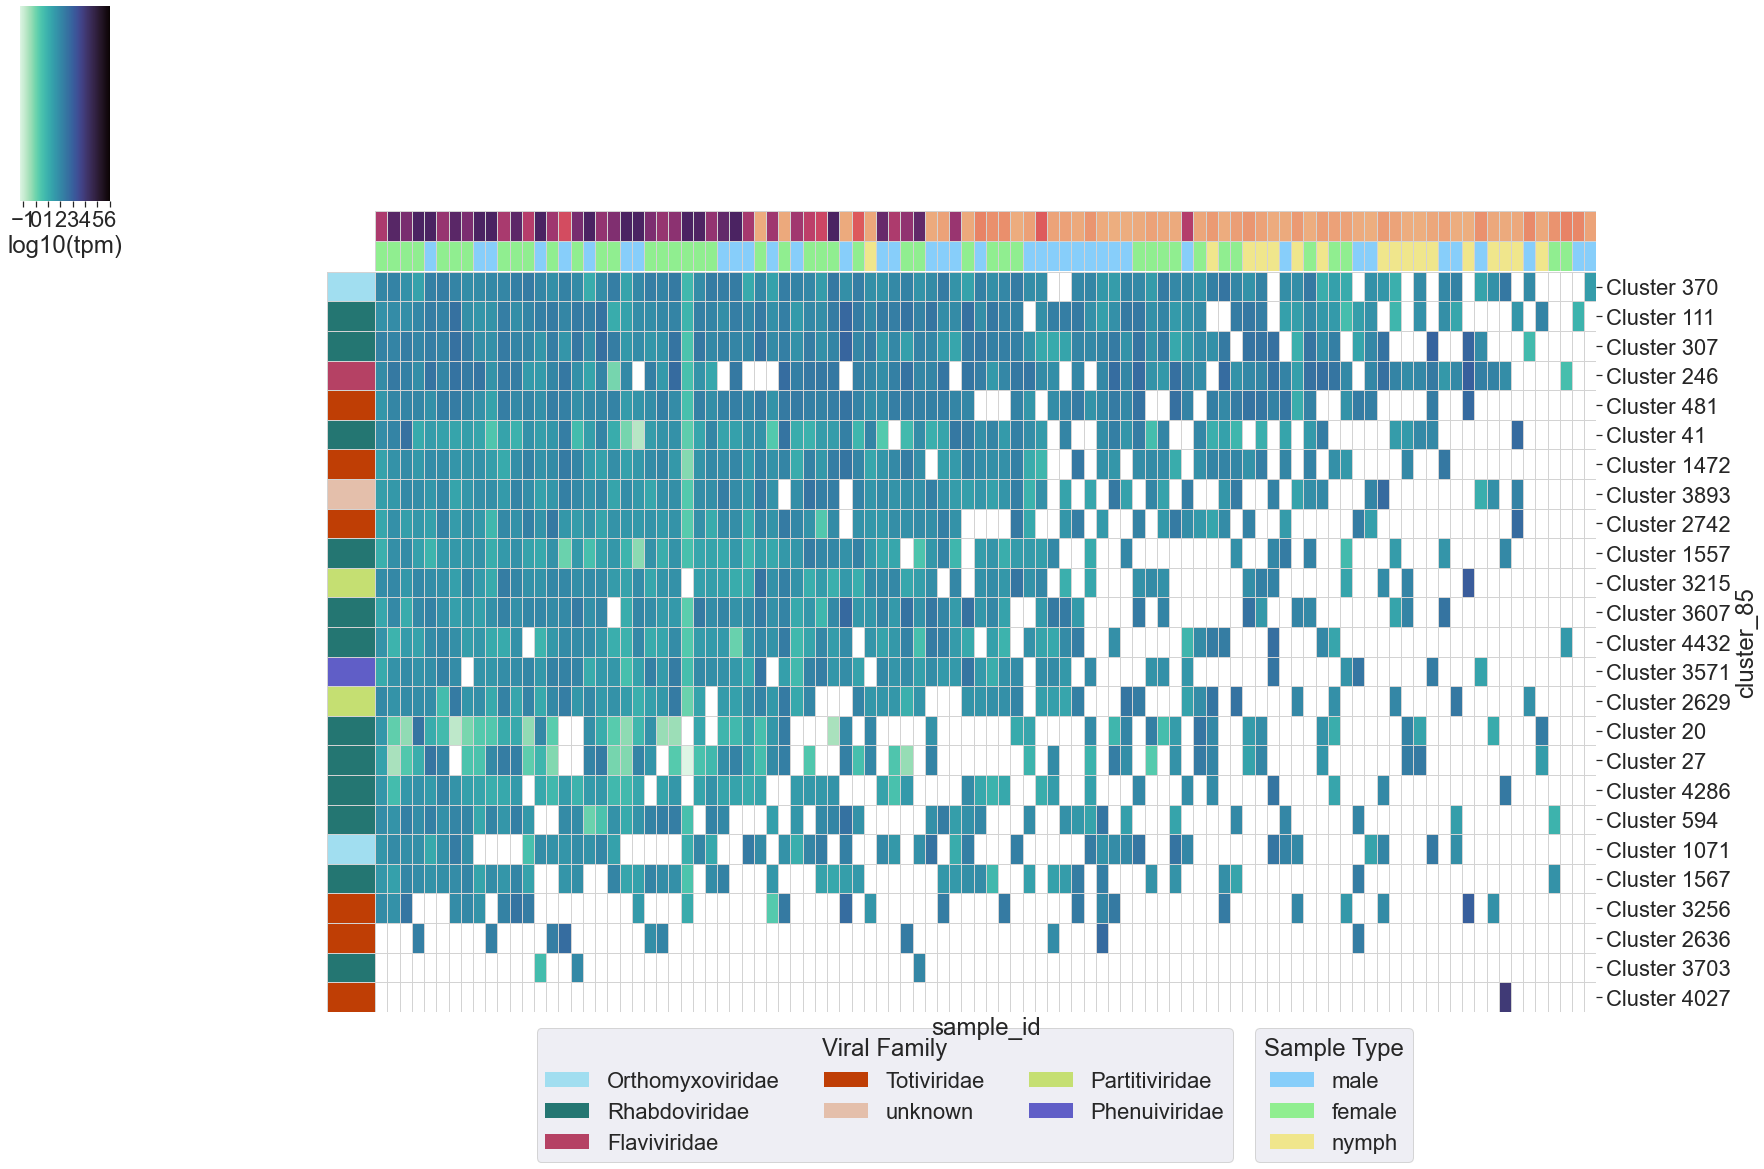

In [11]:
# repeating as above for virus-like transcript
p=vlt_wcov.copy()
p[p>0]=1

vprev=pd.DataFrame(p.sum(axis=1), columns=['n_prev']).reset_index()
vprev['per_prev']=vprev.n_prev/vlt_wcov.shape[1]
sprev=pd.DataFrame(p.sum(axis=0), columns=['n_prev']).reset_index()

sc=AgglomerativeClustering(n_clusters=30, affinity='euclidean', linkage='ward').fit_predict(p.transpose())
sprev['cluster']=sc
colorder=sprev.sort_values(by=['n_prev','cluster'],ascending=False).sample_id

vc=AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage='ward').fit_predict(p)
vprev['cluster']=vc
roworder=vprev.sort_values(by=['n_prev','cluster'],ascending=False).cluster_85

vlt_wcov=vlt_wcov.loc[roworder,colorder]

row_colors = vlt_wcov.index.map(family_dict).map(r_lut)
col_colors=vlt_wcov.columns.map(ls_dict).map(c_lut)
col_colors2=vlt_wcov.columns.map(lib_dict).map(c_lut2)  
    
vlt_log=vlt_wcov.copy()
vlt_log[vlt_log==0]=.000001
vlt_log=np.log10(vlt_log)
vlt_log[vlt_log<=-6]=0

vlt_clust=sns.clustermap(data = vlt_log,cmap = cmap, vmax=6, mask=(vlt_log==0), row_colors=[row_colors],
                     col_colors=[col_colors2, col_colors], yticklabels=1, xticklabels=False, 
                     col_cluster=False, row_cluster=False, figsize=(25,15),linecolor='lightgrey', linewidth=.5,
                           cbar_kws={"ticks":[-1, 0,1,2,3,4,5, 6], 'label': 'log10(tpm)', 
                                     'orientation':"horizontal",'use_gridspec':False})

for label in vlt_wcov.index.map(family_dict).unique():
    vlt_clust.ax_row_dendrogram.bar(0, 0, color=r_lut[label], label=label, linewidth=0);
vlt_clust.ax_row_dendrogram.legend(title='Viral Family', loc="lower right", bbox_to_anchor=(.7,-.1), 
                                   bbox_transform=plt.gcf().transFigure,ncol=3)

for label in c_lut.keys():
    vlt_clust.ax_col_dendrogram.bar(0, 0, color=c_lut[label], label=label, linewidth=0);
vlt_clust.ax_col_dendrogram.legend(title='Sample Type', loc="lower right", bbox_to_anchor=(.8, -.1), 
                                   bbox_transform=plt.gcf().transFigure)


# vlt_clust.savefig('../out/plots/VLS/vlt_clustmap.pdf')

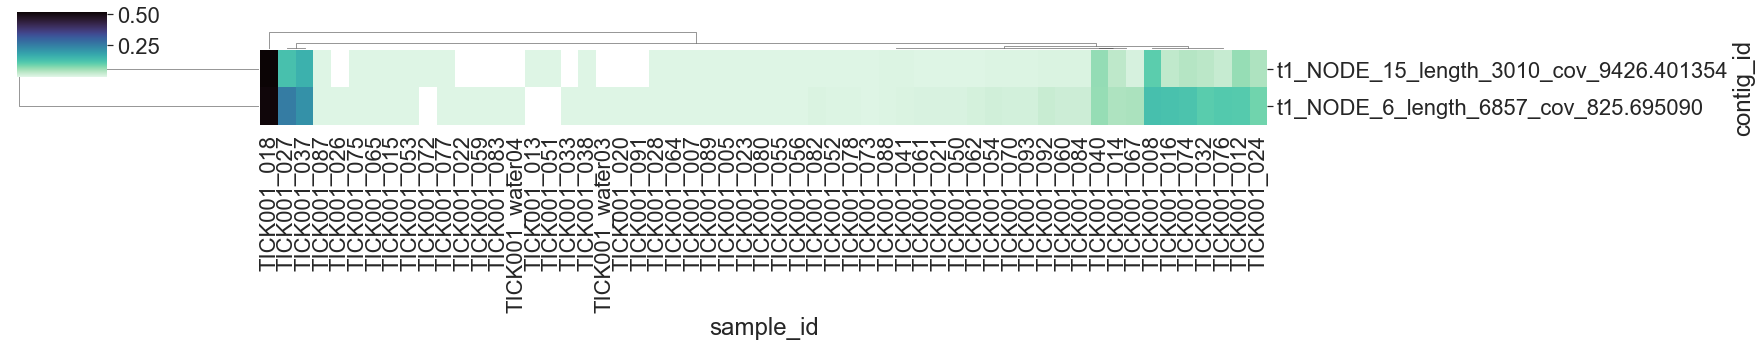

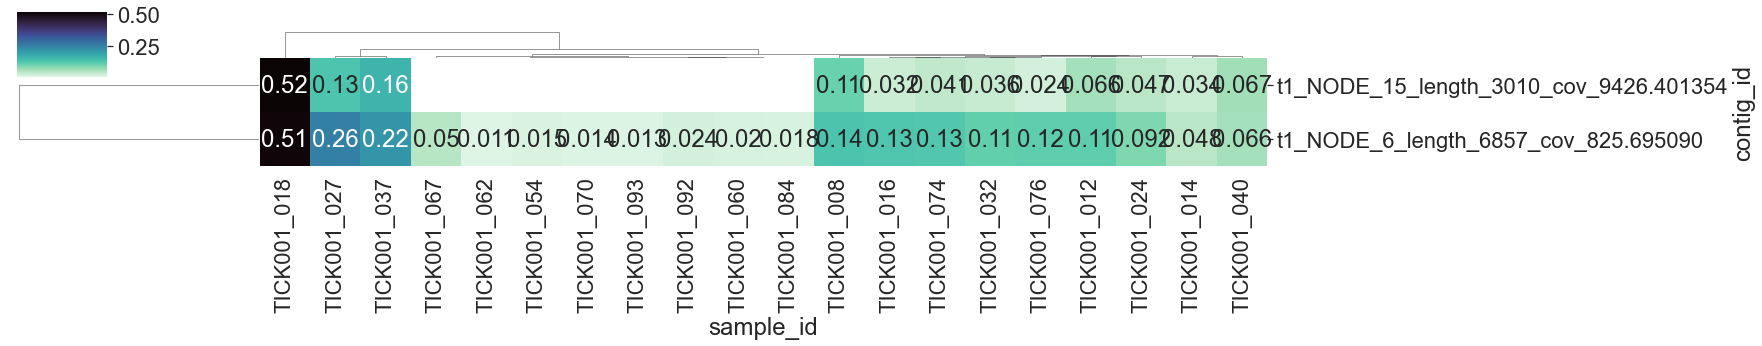

In [37]:
df=cov_long[cov_long.contig_id.isin(['t1_NODE_15_length_3010_cov_9426.401354','t1_NODE_6_length_6857_cov_825.695090'])]
df2=df[(df.mass>100*df.control_mass)&(df.mass>1e-2)]
df_wide=df.pivot(
    columns='sample_id',index='contig_id',values='mass').fillna(0)

sns.clustermap(df_wide,cmap=cmap,mask=df_wide==0,figsize=(25,5),xticklabels=1)

df2_wide=df2.pivot(
    columns='sample_id',index='contig_id',values='mass').fillna(0)

sns.clustermap(df2_wide,cmap=cmap,mask=df2_wide==0,figsize=(25,5),xticklabels=1,annot=True)


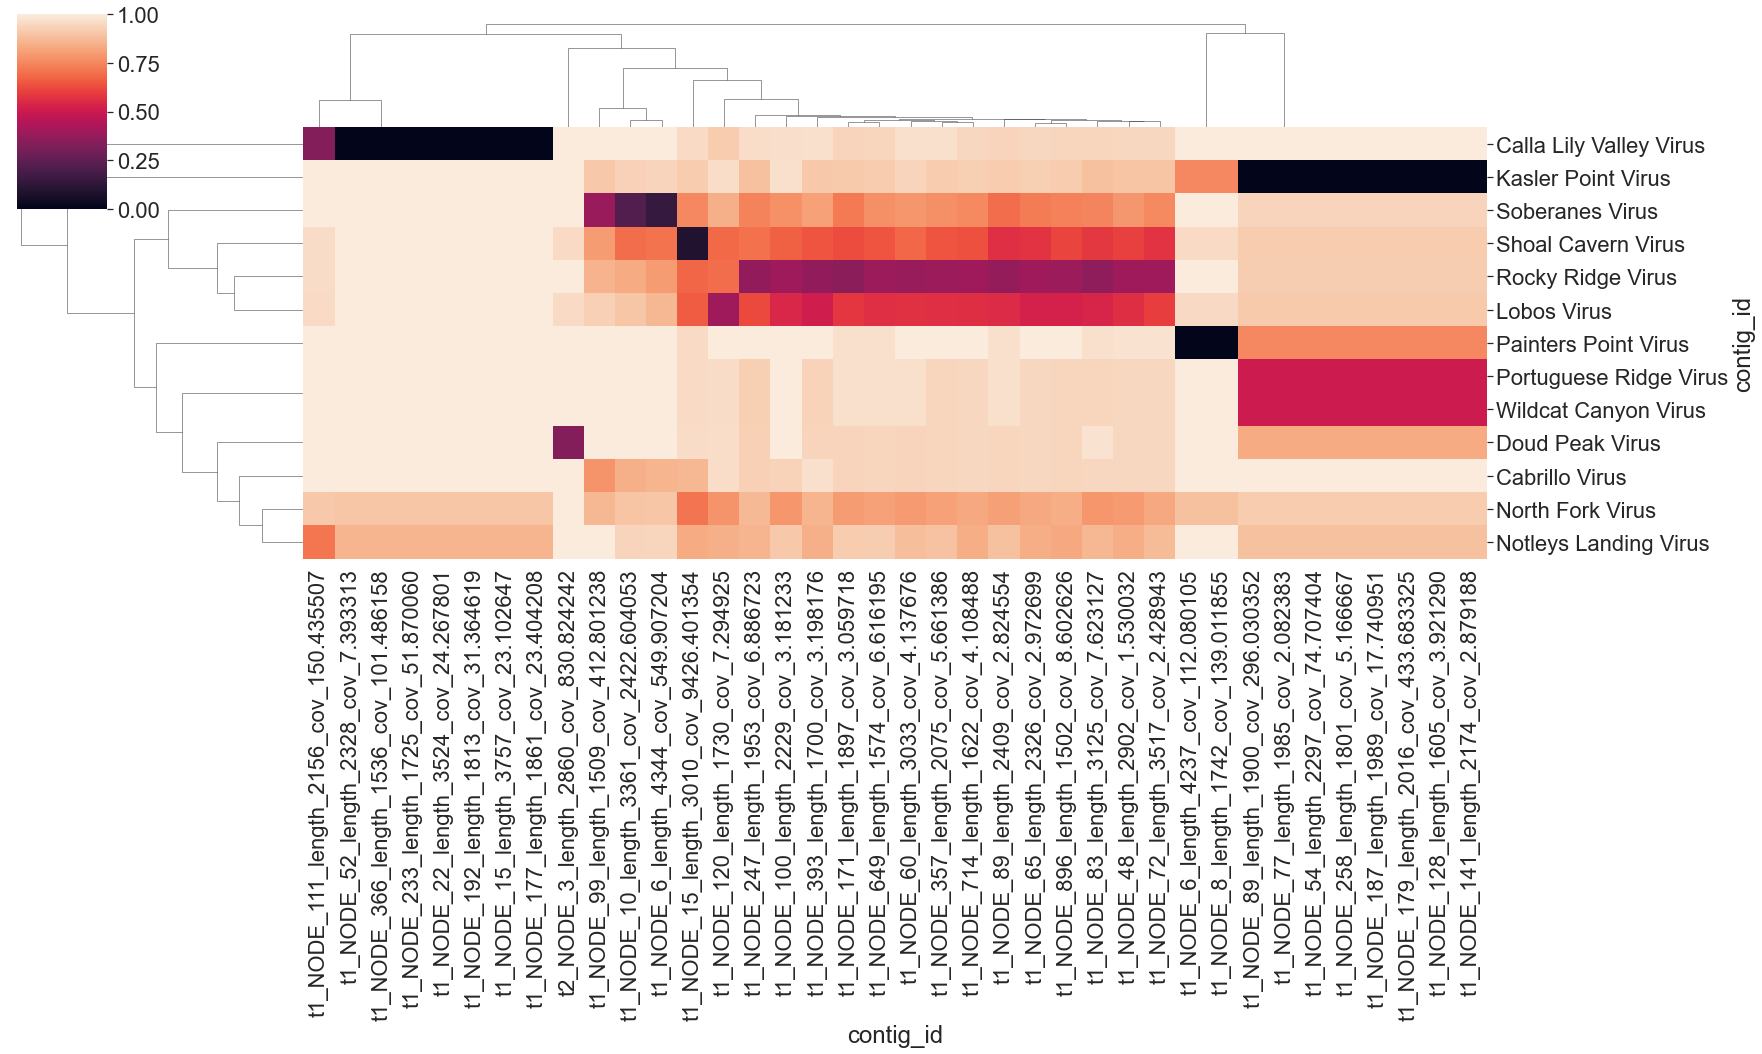

In [93]:
sub_samples=list(sample_sum[sample_sum.nonhost_reads>=1e06].sample_id)
p=cov_long[(cov_long.sample_type=='exp')&
           (cov_long.sample_id.isin(sub_samples))&
           (cov_long.contig_length>=1500)&
          (cov_long.mass>10*cov_long.control_mass)&
           (cov_long.mass>1e-5)]


p=p.pivot(columns='sample_id',index='contig_id',values='tpm').fillna(0)
p[p>0]=1
q=p.loc[virus,:]

x=scipy.spatial.distance.cdist(q,p,metric='jaccard')

d=pd.DataFrame(x,index=q.index, columns=p.index)
d=d.loc[:,d.min()<0.4]
d.drop(columns=list(d.index),inplace=True)
d.index=d.index.map(dict(zip(rdrp_sum.contig_id, rdrp_sum.virus_name)))

# col_colors=d.columns.map(col_dict).map(c_lut)
# row_colors=d.index.map(row_dict).map(r_lut)
sns.clustermap(data = d, yticklabels=1, xticklabels=1, row_cluster=True, 
    col_cluster=True, figsize=(25,15))

# for label in set(row_dict.values()):
#     clust.ax_col_dendrogram.bar(0, 0, color=r_lut[label],
#                                     label=label, linewidth=0)

# for label in set(col_dict.values()):
#     clust.ax_col_dendrogram.bar(0, 0, color=c_lut[label],
#                                     label=label, linewidth=0)
#     clust.ax_row_dendrogram.set_visible(False)
# #     clust.ax_col_dendrogram.set_visible(False)
#     clust.ax_col_dendrogram.set_xlim([0,0])
#     clust.ax_col_dendrogram.legend(bbox_to_anchor=(1, 1),borderaxespad=0)

# clust.savefig('./out/plots/segment_distance.pdf')

In [103]:
cc_contigs=list(d.columns)
input_seq_iterator=SeqIO.parse('../out/assemblies/t1_t2_all_500.fasta','fasta')
seqs=[r for r in input_seq_iterator if r.id in (cc_contigs)]
SeqIO.write(seqs, './cooccurring_contigs.fasta', 'fasta')

In [150]:
cc_annot=pd.read_csv('./cooccurring_contigs_blast.tsv')
cc_annot.sort_values(by='bitscore', ascending=False,inplace=True)
cc_annot.drop_duplicates(subset=['contig_id'], keep='first',inplace=True)
cc_annot

,contig_id,qlen,qframe,qstart,qend,sseqid,slen,evalue,bitscore,a_length,pident,nident,gaps,staxids,sname,org,superkingdom,clade,kingdom,order,family,genus,species,no_rank
0,t1_NODE_6_length_4237_cov_112.080105,4237,-3,4184,204,BBD75426.1,1350,0.000000e+00,1663.7,1351,58.3,788,26,1752929,BBD75426.1 glycoprotein precursor [Ixodes scap...,Ixodes scapularis bunyavirus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,unclassified Peribunyaviridae,Ixodes scapularis bunyavirus,unclassified Peribunyaviridae
84,t1_NODE_6_length_4344_cov_549.907204,4344,-2,4211,285,BBD75426.1,1350,9.000000e-233,818.1,1334,35.2,469,56,1752929,BBD75426.1 glycoprotein precursor [Ixodes scap...,Ixodes scapularis bunyavirus,Viruses,Riboviria,Orthornavirae,Bunyavirales,Peribunyaviridae,unclassified Peribunyaviridae,Ixodes scapularis bunyavirus,unclassified Peribunyaviridae
238,t1_NODE_52_length_2328_cov_7.393313,2328,1,28,2280,QIS88059.1,756,6.300000e-217,764.6,756,50.0,378,9,2707218,QIS88059.1 VP4 [Fennes virus],Fennes virus,Viruses,Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,Fennes virus,unclassified Riboviria
50,t1_NODE_15_length_3757_cov_23.102647,3757,-1,3574,665,QIS88058.1,1028,5.600000e-215,758.8,972,40.2,391,3,2707218,"QIS88058.1 VP2, partial [Fennes virus]",Fennes virus,Viruses,Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,Fennes virus,unclassified Riboviria
330,t1_NODE_72_length_3517_cov_2.428943,3517,3,396,2360,XP_029838538.1,661,1.500000e-153,554.7,681,46.4,316,47,6945,XP_029838538.1 uncharacterized protein LOC1153...,Ixodes scapularis,Eukaryota,Panarthropoda,Metazoa,Ixodida,Ixodidae,Ixodes,Ixodes scapularis,cellular organisms
25,t1_NODE_15_length_3010_cov_9426.401354,3010,-2,2883,1465,ASY03239.1,443,6.200000e-148,535.8,473,61.7,292,38,2034330,ASY03239.1 nucleocapsid protein [Norway phlebo...,Norway phlebovirus 1,Viruses,Riboviria,Orthornavirae,Bunyavirales,Phenuiviridae,Ixovirus,Norway ixovirus,Norway ixovirus
65,t1_NODE_177_length_1861_cov_23.404208,1861,2,35,1801,QIS88060.1,605,3.300000e-75,293.5,602,30.6,184,29,2707218,QIS88060.1 VP10 [Fennes virus],Fennes virus,Viruses,Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,unclassified Riboviria,Fennes virus,unclassified Riboviria
109,t1_NODE_99_length_1509_cov_412.801238,1509,3,282,980,EEC09874.1,332,1.100000e-52,218.4,233,48.1,112,2,6945,EEC09874.1 hypothetical protein IscW_ISCW00770...,Ixodes scapularis,Eukaryota,Panarthropoda,Metazoa,Ixodida,Ixodidae,Ixodes,Ixodes scapularis,cellular organisms
368,t2_NODE_3_length_2860_cov_830.824242,2860,2,947,1441,CDW75723.1,1881,3.000000e-51,214.5,165,67.3,111,5,5949,CDW75723.1 UNKNOWN [Stylonychia lemnae],Stylonychia lemnae,Eukaryota,Alveolata,cellular organisms,Sporadotrichida,Oxytrichidae,Stylonychia,Stylonychia lemnae,cellular organisms
180,t1_NODE_54_length_2297_cov_74.707404,2297,-1,2072,1404,KRH17783.2,947,6.800000e-30,143.3,223,41.3,92,81,3847,KRH17783.2 LOW QUALITY PROTEIN: hypothetical p...,Glycine max,Eukaryota,indigoferoid/millettioid clade,Viridiplantae,Fabales,Fabaceae,Glycine,Glycine max,cellular organisms


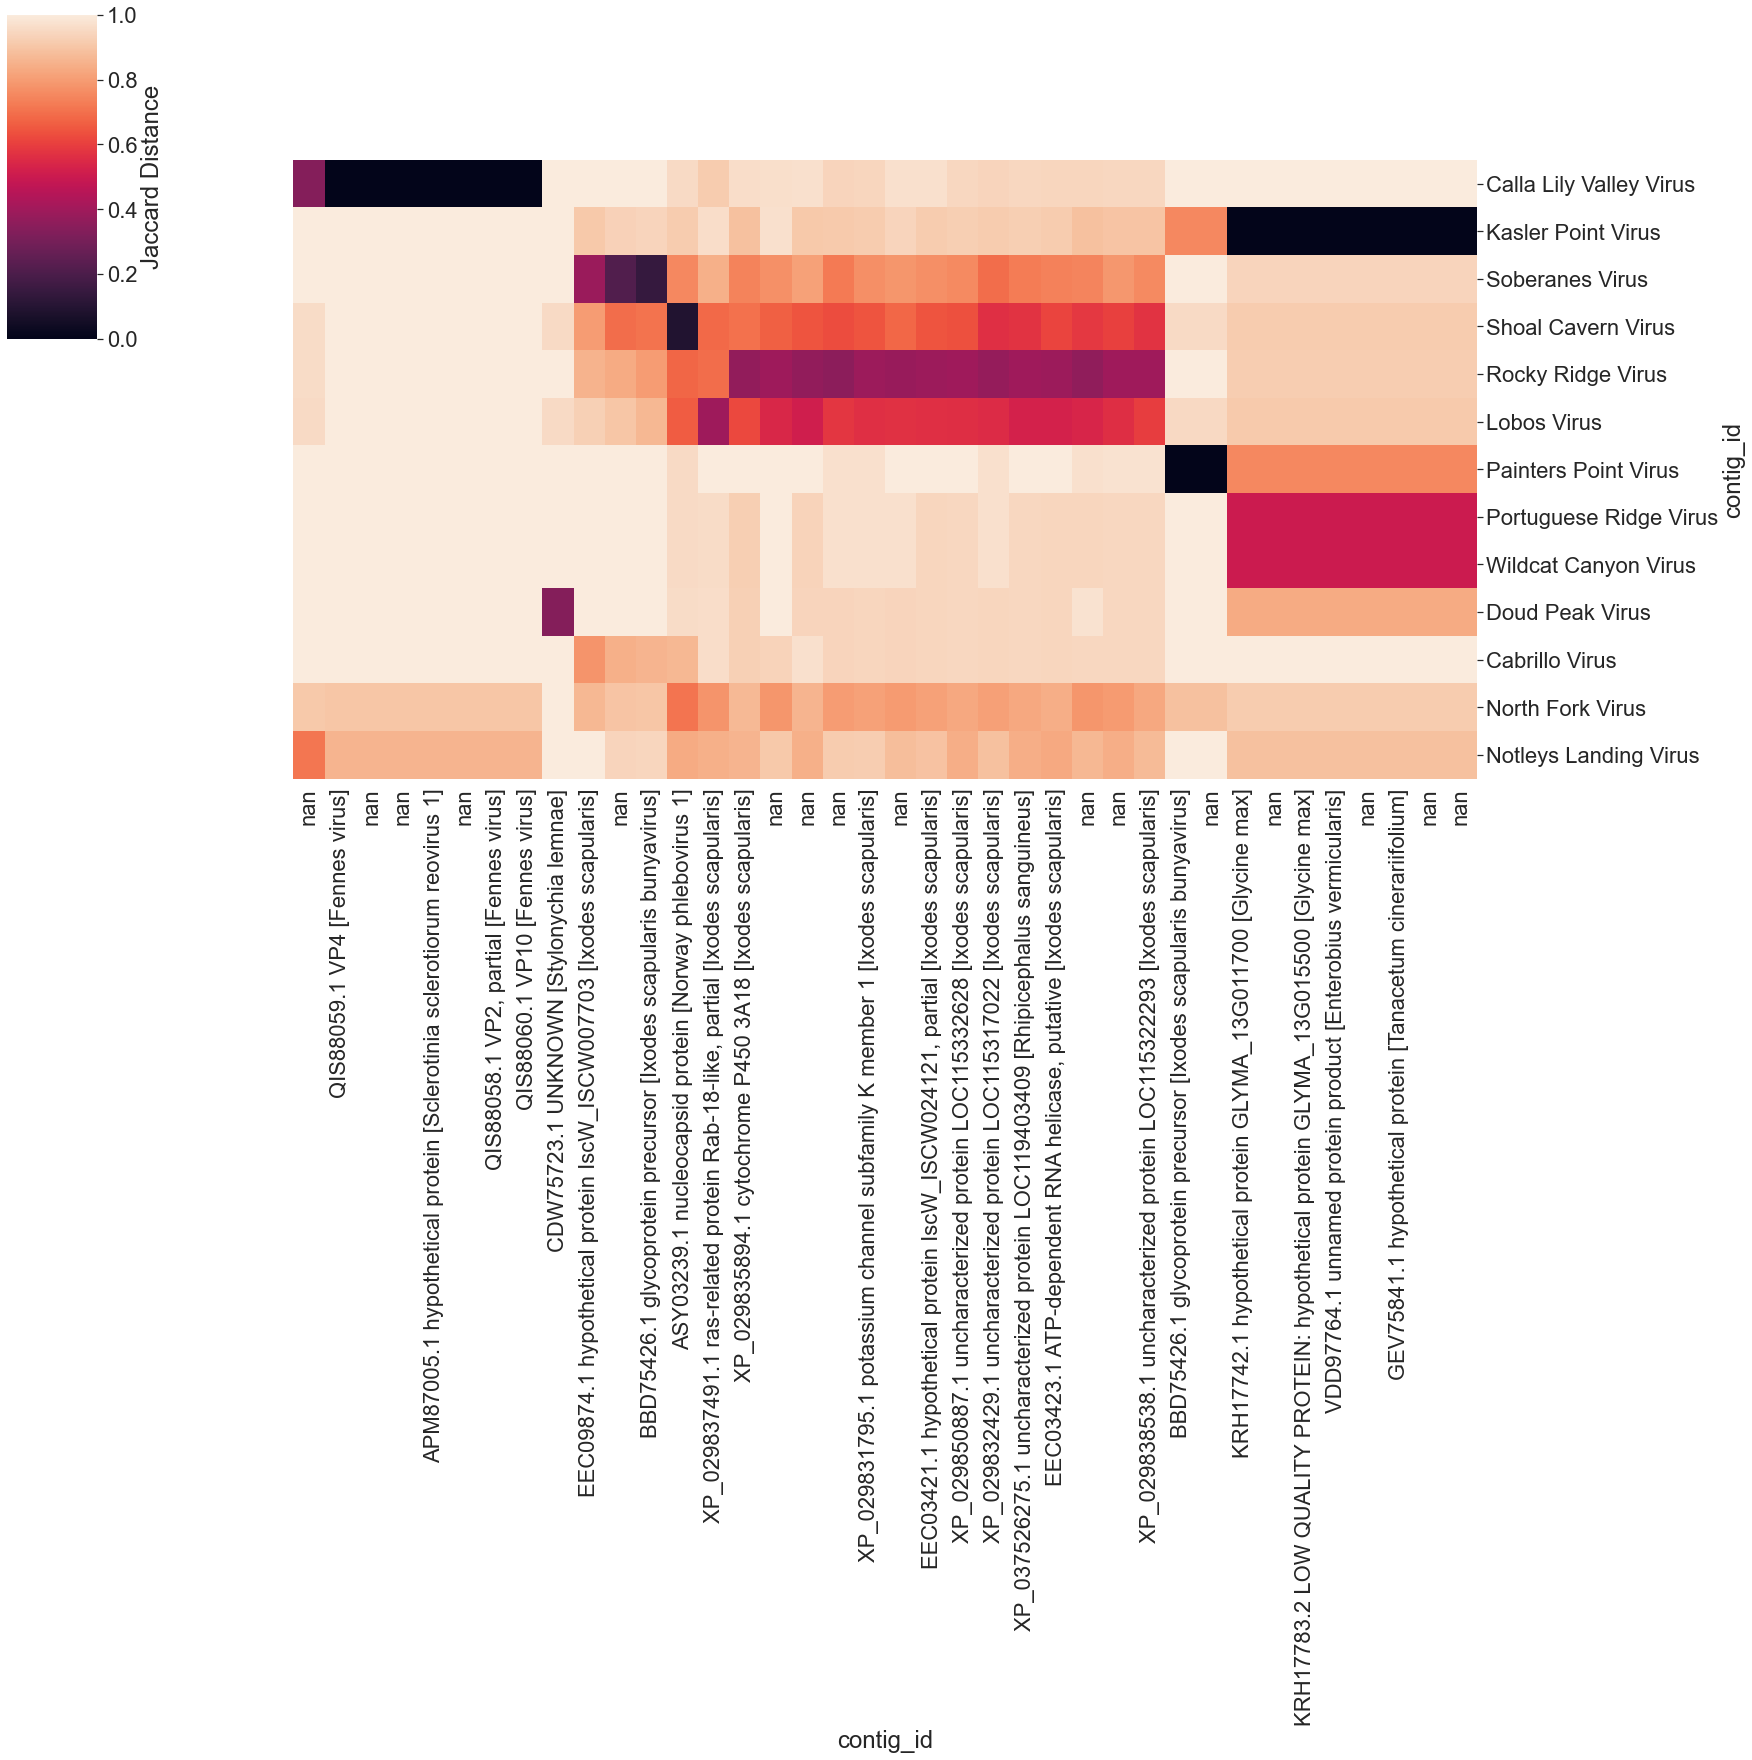

In [164]:
# d.columns=d.columns.map(dict(zip(cc_annot.contig_id, cc_annot.sname)))
cc_clust=sns.clustermap(data = d, yticklabels=1, xticklabels=1, row_cluster=True, 
    col_cluster=True, figsize=(25,25), cbar_kws={'label': 'Jaccard Distance'})
cc_clust.ax_row_dendrogram.set_visible(False)
cc_clust.ax_col_dendrogram.set_visible(False)
cc_clust.savefig('./co-occurring_clustmap.pdf')

# Bacteria

In [13]:
kraken=pd.read_csv('./out/kraken/classified_kraken.csv')
kraken=kraken[(kraken.unique_minimizers>100)&(kraken.rpm>100*kraken.control_rpm)&(kraken['type']=='exp')]
genus=kraken[kraken['rank']=='G']
genus_prev=genus.pivot(index='name', columns='sample',values='rpm').fillna(0)
missing=[x for x in samples  if x not in genus['sample'].unique()]
d = dict.fromkeys(missing, 0)
genus_prev=genus_prev.assign(**d)
genus_prev[genus_prev>0]=1
genus_prev=genus_prev[p.columns]

In [69]:
kraken[kraken.name=='Alicycliphilus']

,percent_reads,no_reads,no_direct_reads,minimizers,unique_minimizers,rank,taxid,name,sample,dataset,...,total,scale,rpm,rpm_direct,control_rpm,classified_sum,classify_percent,class,family,genus
18579,0.02,48,0,887,244,G,201096,Alicycliphilus,TICK001_013,Garrapatta,...,278339,0.278339,172.451579,0.0,0.0,109987,0.000436,Betaproteobacteria,Comamonadaceae,Alicycliphilus
21424,0.03,109,0,1815,377,G,201096,Alicycliphilus,TICK001_091,Garrapatta,...,381203,0.381203,285.936889,0.0,0.0,311550,0.000350,Betaproteobacteria,Comamonadaceae,Alicycliphilus
37615,0.07,83,0,846,306,G,201096,Alicycliphilus,TICK001_023,Garrapatta,...,127642,0.127642,650.256185,0.0,0.0,94414,0.000879,Betaproteobacteria,Comamonadaceae,Alicycliphilus
61274,0.02,76,0,2043,302,G,201096,Alicycliphilus,TICK001_020,Garrapatta,...,332010,0.332010,228.908768,0.0,0.0,242207,0.000314,Betaproteobacteria,Comamonadaceae,Alicycliphilus
64868,0.01,29,0,290,185,G,201096,Alicycliphilus,TICK001_077,Garrapatta,...,287199,0.287199,100.975282,0.0,0.0,62336,0.000465,Betaproteobacteria,Comamonadaceae,Alicycliphilus
84062,0.01,67,0,957,265,G,201096,Alicycliphilus,TICK001_021,Garrapatta,...,702159,0.702159,95.419983,0.0,0.0,108868,0.000615,Betaproteobacteria,Comamonadaceae,Alicycliphilus
88572,0.05,73,0,880,284,G,201096,Alicycliphilus,TICK001_038,Garrapatta,...,137746,0.137746,529.960943,0.0,0.0,104577,0.000698,Betaproteobacteria,Comamonadaceae,Alicycliphilus
103728,0.01,9,0,161,102,G,201096,Alicycliphilus,TICK001_087,Garrapatta,...,144979,0.144979,62.077956,0.0,0.0,42923,0.000210,Betaproteobacteria,Comamonadaceae,Alicycliphilus
158923,0.02,74,0,2552,308,G,201096,Alicycliphilus,TICK001_007,Garrapatta,...,350973,0.350973,210.842429,0.0,0.0,229259,0.000323,Betaproteobacteria,Comamonadaceae,Alicycliphilus
174690,0.03,71,0,1284,362,G,201096,Alicycliphilus,TICK001_064,Garrapatta,...,259223,0.259223,273.895449,0.0,0.0,215891,0.000329,Betaproteobacteria,Comamonadaceae,Alicycliphilus


In [213]:
max(gp.loc['Anaplasma'])

14980.127446603246

<ipython-input-205-63addb166375>:18: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("mako_r").copy()
  cmap.set_bad("white")
/Users/callamartyn/opt/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


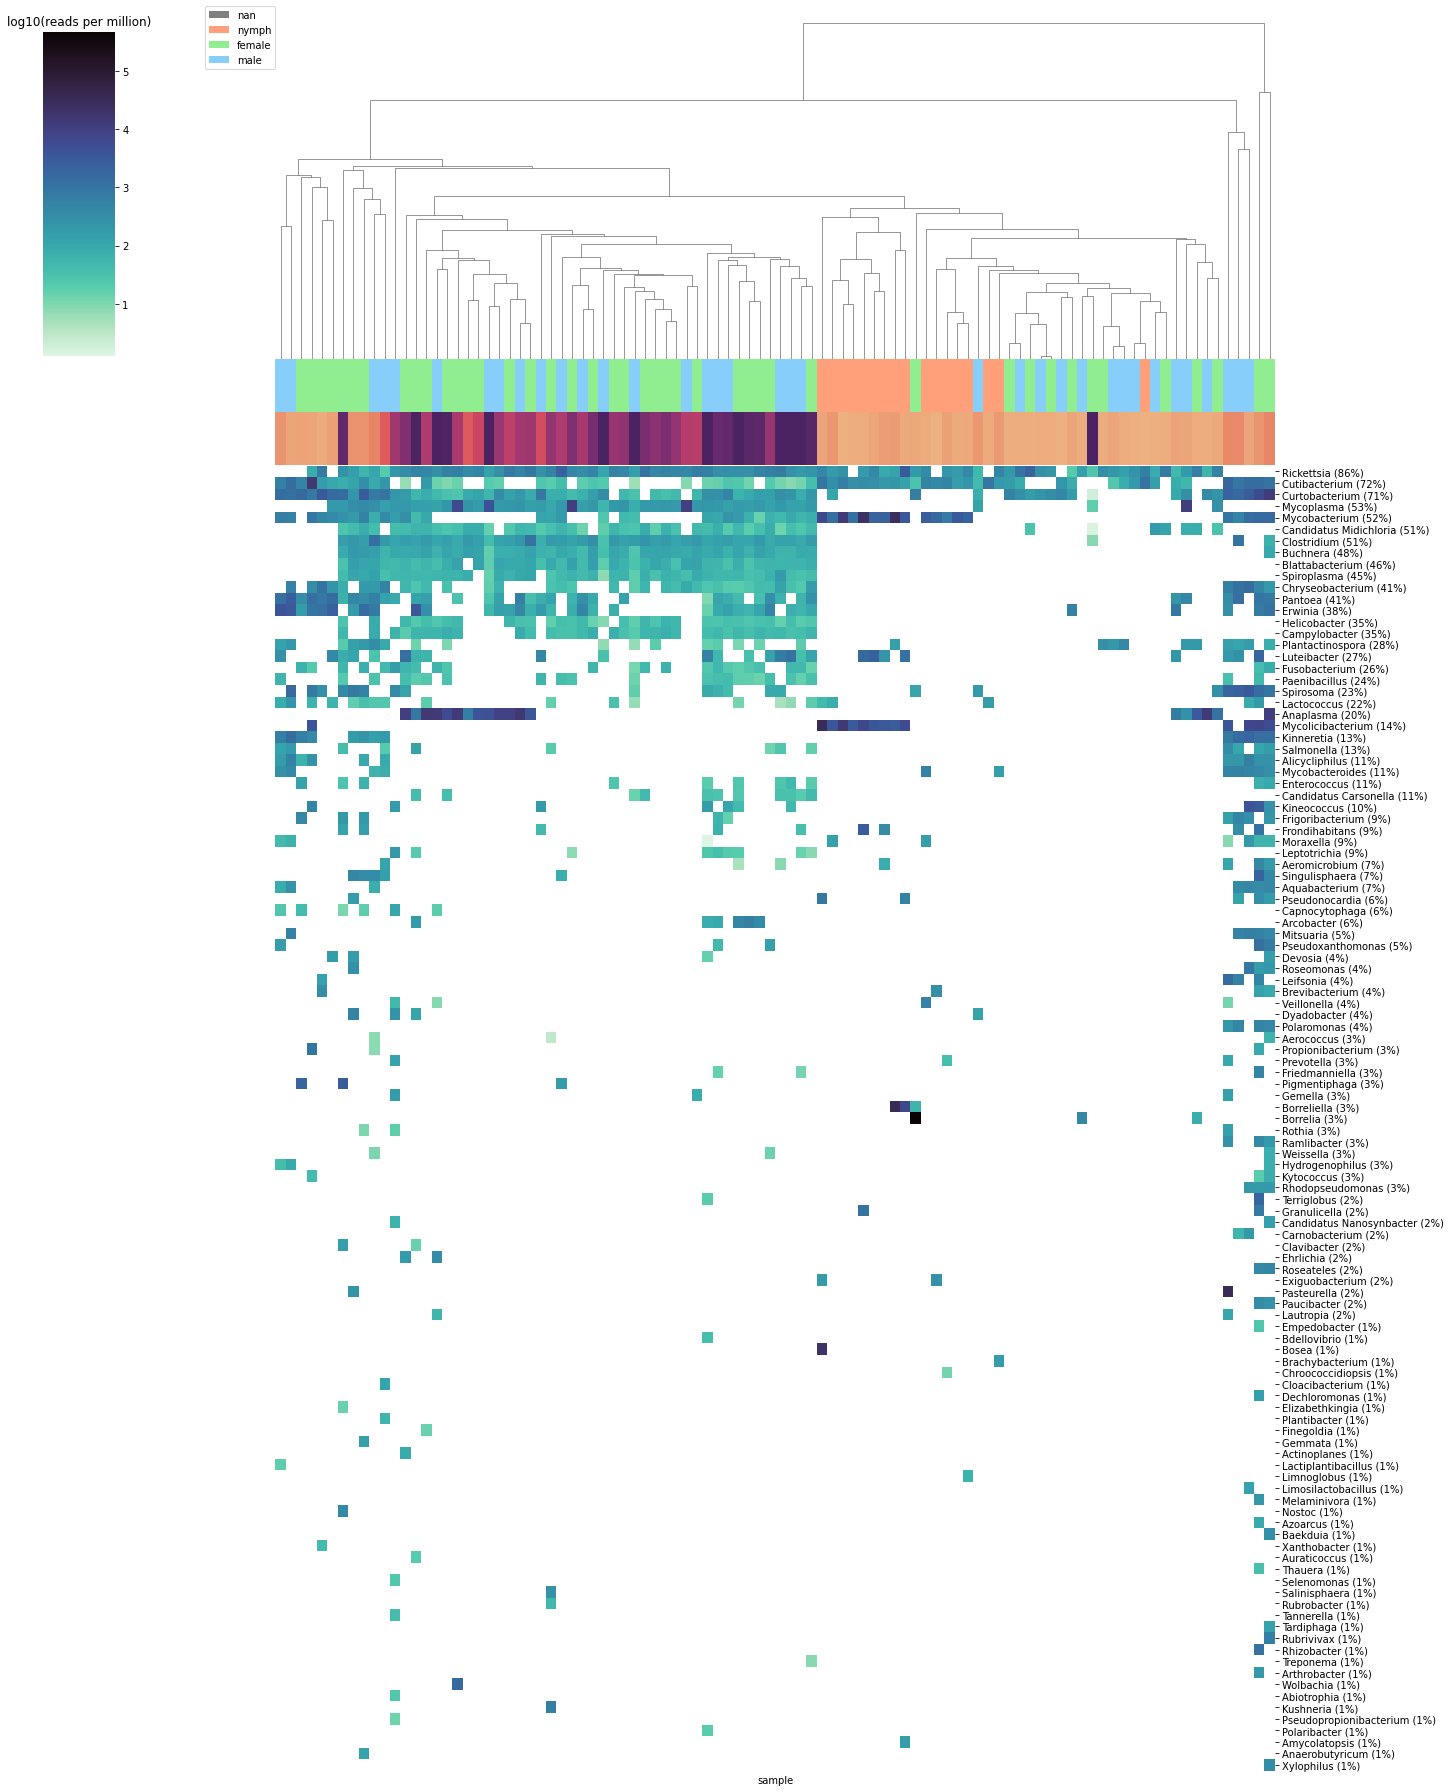

In [205]:
gp=genus.pivot(index='name', columns='sample',values='rpm').fillna(0)
row_order=gp.assign(sum=(gp>0).sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:, :-1].index
gp=gp.loc[row_order,]
# gp=gp[(gp>0).sum(axis=1)>n] #select rows with more than n observations
gp_log=gp.copy()
gp_log[gp_log==0]=.000001
gp_log=np.log10(gp_log)
gp_log[gp_log<=-6]=0

gp_log=gp_log.assign(total=((gp_log>0).sum(axis=1)))
gp_log=gp_log.sort_values(by='total', ascending=False)
gp_index=gp_log.index
gp_log=gp_log.assign(prev=(gp_log.total/gp_log.shape[1])*100)
gp_log=gp_log.set_index(gp_log.index+' ('+round(gp_log.prev).astype('int').astype('string')+'%)')
gp_log=gp_log.iloc[:, :-2]

cmap = sns.cm.mako_r
cmap.set_bad("white") 
    

ss=pd.read_csv('./sample_sex.csv')
s_dict=dict(zip(ss.sample_id, ss.sex))

c_lut=dict(zip(ss.sex.unique(), ('grey', 'lightskyblue', 'lightgreen', 'lightsalmon')))
col_colors=gp_log.columns.map(s_dict).map(c_lut)

cmap2 = sns.cm.flare
libs=list(libsize.values())
norm = Normalize(vmin=min(libs), vmax=4e6)
rgba_values = cmap2(norm(libs))
c_lut2=dict(zip(libs, cmap2(norm(libs))))
col_colors2=gp_log.columns.map(libsize).map(c_lut2)

bac_clust=sns.clustermap(gp_log, cmap=cmap, mask=gp_log==0, yticklabels=1, col_colors=[col_colors,col_colors2], 
                         figsize=(20,25),row_cluster=False, xticklabels=False)
for label in set(s_dict.values()):
        bac_clust.ax_col_dendrogram.bar(0, 0, color=c_lut[label],
                                    label=label, linewidth=0)
    
bac_clust.ax_col_dendrogram.legend(bbox_to_anchor=(0, 1),borderaxespad=0)
bac_clust.ax_cbar.set_title('log10(reads per million)')
bac_clust.savefig('./out/plots/bacteria_clustmap.pdf')


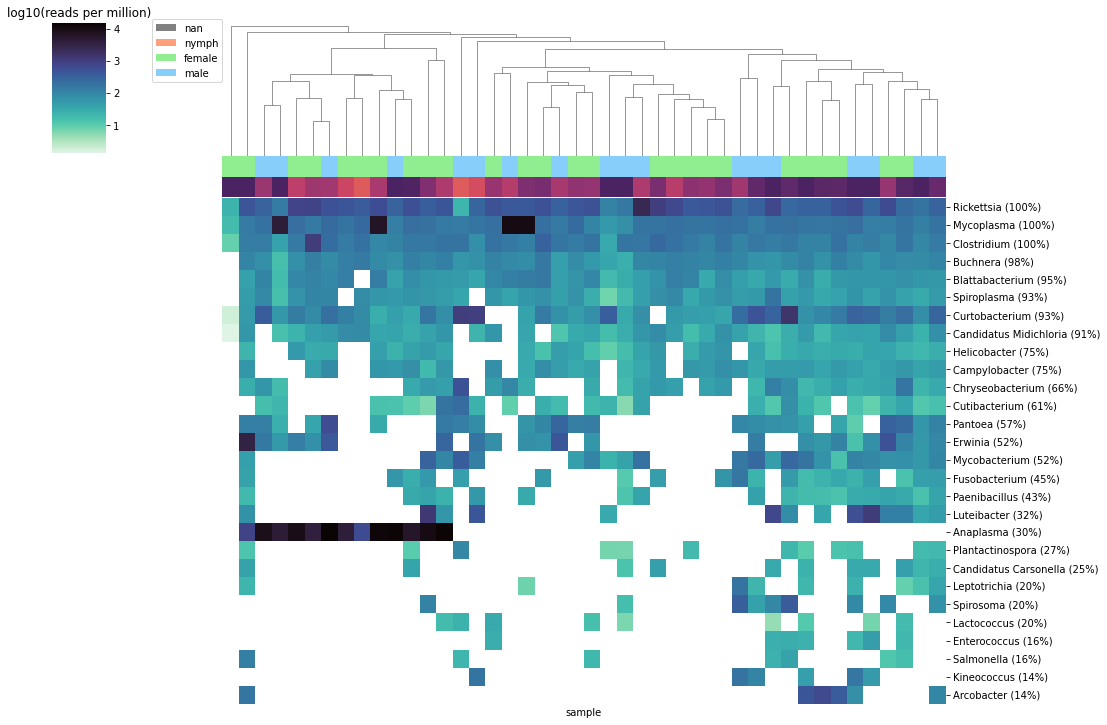

In [204]:
gp_log=gp_log.set_index(gp_index)
n=5
keep=list(sample_sum[sample_sum.nonhost_reads>=1e6]['sample_id'])
trunc=gp_log.loc[:,keep]
trunc=trunc.assign(total=((trunc>0).sum(axis=1)))
trunc=trunc[trunc.total>=n].sort_values(by='total', ascending=False)
trunc=trunc.assign(prev=(trunc.total/len(keep))*100)
trunc=trunc.set_index(trunc.index+' ('+round(trunc.prev).astype('int').astype('string')+'%)')
trunc=trunc.iloc[:, :-2]
col_colors=trunc.columns.map(s_dict).map(c_lut)
col_colors2=trunc.columns.map(libsize).map(c_lut2)
trunc_clust=sns.clustermap(trunc, cmap=cmap, mask=trunc==0, yticklabels=1, col_colors=[col_colors,col_colors2], 
                         figsize=(15,10),row_cluster=False, xticklabels=False)
for label in set(s_dict.values()):
        trunc_clust.ax_col_dendrogram.bar(0, 0, color=c_lut[label],
                                    label=label, linewidth=0)
    
trunc_clust.ax_col_dendrogram.legend(bbox_to_anchor=(0, 1),borderaxespad=0)
trunc_clust.ax_cbar.set_title('log10(reads per million)')
trunc_clust.savefig('./out/plots/bacteria_clustmap_5.pdf')


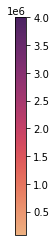

In [186]:
fig,ax = plt.subplots()
sm = plt.cm.ScalarMappable(cmap=cmap2, norm=norm)
plt.colorbar(sm)
ax.remove()
plt.savefig('./out/plots/bacteria/libsize_colorbar.pdf')


In [140]:
round(trunc.prev).astype('int')

name
Rickettsia                100
Mycoplasma                100
Clostridium               100
Buchnera                   98
Blattabacterium            95
Spiroplasma                93
Curtobacterium             93
Candidatus Midichloria     91
Campylobacter              75
Helicobacter               75
Chryseobacterium           66
Cutibacterium              61
Pantoea                    57
Erwinia                    52
Mycobacterium              52
Fusobacterium              45
Paenibacillus              43
Luteibacter                32
Anaplasma                  30
Plantactinospora           27
Candidatus Carsonella      25
Leptotrichia               20
Spirosoma                  20
Lactococcus                20
Salmonella                 16
Enterococcus               16
Kineococcus                14
Arcobacter                 14
Name: prev, dtype: int64

In [150]:
n=5
keep=list(sample_sum[sample_sum.nonhost_reads>=1e6]['sample_id'])
trunc=gp_log.loc[:,keep]
trunc=trunc.assign(total=((trunc>0).sum(axis=1)))
trunc=trunc[trunc.total>=n].sort_values(by='total', ascending=False)
trunc=trunc.assign(prev=(trunc.total/len(keep))*100)
trunc.iloc[:, -2:].to_csv('./out/top_genera_table.csv')
# trunc=trunc.set_index(trunc.index+' ('+round(trunc.prev).astype('int').astype('string')+'%)')
# trunc.iloc[:, -2:]

In [113]:
df=trunc.assign(sum=(trunc>0).sum(axis=1))
df.index+' ('+df['sum'].astype('string')+')'

name
Rickettsia                            Rickettsia (44)
Mycoplasma                            Mycoplasma (44)
Clostridium                          Clostridium (44)
Buchnera                                Buchnera (43)
Blattabacterium                  Blattabacterium (42)
Curtobacterium                    Curtobacterium (41)
Spiroplasma                          Spiroplasma (41)
Candidatus Midichloria    Candidatus Midichloria (40)
Campylobacter                      Campylobacter (33)
Helicobacter                        Helicobacter (33)
Chryseobacterium                Chryseobacterium (29)
Cutibacterium                      Cutibacterium (27)
Pantoea                                  Pantoea (25)
Erwinia                                  Erwinia (23)
Mycobacterium                      Mycobacterium (23)
Fusobacterium                      Fusobacterium (20)
Paenibacillus                      Paenibacillus (19)
Luteibacter                          Luteibacter (14)
Anaplasma              

<AxesSubplot:xlabel='sample', ylabel='name'>

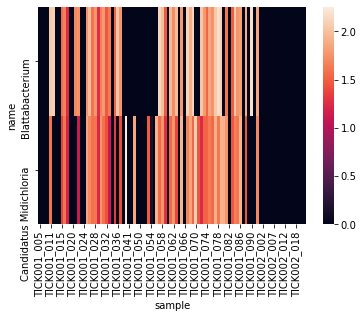

In [67]:
sns.heatmap(gp_log.loc[['Blattabacterium', 'Candidatus Midichloria']])

<AxesSubplot:xlabel='sample', ylabel='name'>

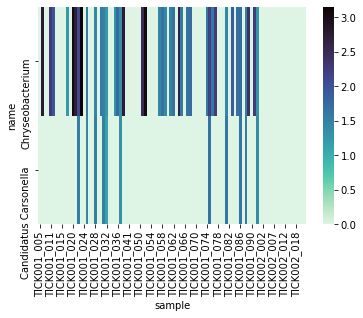

In [60]:
sns.heatmap(gp_log.loc[['Chryseobacterium', 'Candidatus Carsonella']],cmap=cmap)

In [48]:
keep=list(sample_sum[sample_sum.nonhost_reads>=500000]['sample_id'])
gp_log.loc[:,keep]


sample,TICK001_011,TICK001_020,TICK001_021,TICK001_064,TICK001_077,TICK001_078,TICK001_027,TICK001_028,TICK001_036,TICK001_054,...,TICK001_056,TICK001_061,TICK001_065,TICK001_062,TICK001_030,TICK001_033,TICK001_029,TICK001_018,TICK001_015,TICK001_013
name,,,,,,,,,,,,,,,,,,,,,
Rickettsia,2.043300,0.000000,1.329656,0.000000,1.772266,2.185920,2.488813,2.791842,2.491077,1.379506,...,2.579643,2.719379,2.796541,2.654320,3.377779,2.502619,2.053664,2.136450,2.439634,0.000000
Cutibacterium,1.976353,2.968807,2.343896,3.148619,2.500858,2.076775,1.146390,1.151089,1.213364,0.000000,...,0.000000,1.284455,1.354921,2.274913,1.588290,1.249545,1.364833,1.318004,1.394497,2.780735
Curtobacterium,2.898617,3.240025,3.000520,3.781118,3.470213,2.358782,1.661716,2.490511,2.559361,0.279710,...,1.939065,1.861692,2.133073,1.891214,1.870015,1.820936,2.547190,1.743973,2.972645,3.148712
Mycoplasma,2.484509,0.000000,2.153565,0.000000,2.583210,2.514978,2.107238,2.327181,2.289242,1.241922,...,2.389712,2.017444,2.128378,2.165769,2.273837,2.176636,1.730417,3.638367,2.236631,0.000000
Mycobacterium,1.882449,2.704158,2.565184,3.221810,2.748643,2.248711,0.000000,2.060710,0.000000,0.000000,...,0.000000,2.029183,1.845831,2.001912,2.279641,0.000000,1.391817,0.000000,2.085115,2.820244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Limosilactobacillus,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Melaminivora,0.000000,0.000000,0.000000,2.364478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Nostoc,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [53]:
gp_log[(gp_log>0).sum(axis=1)>n].loc[:,keep]

sample,TICK001_011,TICK001_020,TICK001_021,TICK001_064,TICK001_077,TICK001_078,TICK001_027,TICK001_028,TICK001_036,TICK001_054,...,TICK001_056,TICK001_061,TICK001_065,TICK001_062,TICK001_030,TICK001_033,TICK001_029,TICK001_018,TICK001_015,TICK001_013
name,,,,,,,,,,,,,,,,,,,,,
Rickettsia,2.043300,0.000000,1.329656,0.000000,1.772266,2.185920,2.488813,2.791842,2.491077,1.379506,...,2.579643,2.719379,2.796541,2.654320,3.377779,2.502619,2.053664,2.136450,2.439634,0.000000
Cutibacterium,1.976353,2.968807,2.343896,3.148619,2.500858,2.076775,1.146390,1.151089,1.213364,0.000000,...,0.000000,1.284455,1.354921,2.274913,1.588290,1.249545,1.364833,1.318004,1.394497,2.780735
Curtobacterium,2.898617,3.240025,3.000520,3.781118,3.470213,2.358782,1.661716,2.490511,2.559361,0.279710,...,1.939065,1.861692,2.133073,1.891214,1.870015,1.820936,2.547190,1.743973,2.972645,3.148712
Mycoplasma,2.484509,0.000000,2.153565,0.000000,2.583210,2.514978,2.107238,2.327181,2.289242,1.241922,...,2.389712,2.017444,2.128378,2.165769,2.273837,2.176636,1.730417,3.638367,2.236631,0.000000
Mycobacterium,1.882449,2.704158,2.565184,3.221810,2.748643,2.248711,0.000000,2.060710,0.000000,0.000000,...,0.000000,2.029183,1.845831,2.001912,2.279641,0.000000,1.391817,0.000000,2.085115,2.820244
Candidatus Midichloria,1.596142,0.000000,0.000000,0.000000,1.903545,1.611888,1.581619,1.605703,0.000000,0.154772,...,1.932003,1.543288,1.928018,1.767829,1.764382,1.111243,1.228614,1.180831,1.351032,0.000000
Clostridium,3.098569,3.010328,2.274138,0.000000,2.213915,2.310858,2.053208,2.059087,2.121361,0.932923,...,2.280212,2.257925,1.970770,2.259191,2.224386,2.233458,1.506163,1.605246,1.857608,0.000000
Buchnera,2.168239,0.000000,1.776814,0.000000,2.249387,2.303559,1.845360,1.944329,1.853212,0.000000,...,2.180097,1.739582,1.990665,2.095917,2.001079,1.631398,1.562644,1.204964,1.828153,0.000000
Blattabacterium,2.053519,0.000000,1.697633,0.000000,2.046967,2.185920,1.587082,1.775590,2.029304,0.000000,...,0.000000,1.980196,1.761187,1.722072,1.657926,1.631398,1.258069,1.249547,1.563640,0.000000
